In [1]:
!pip install -q transformers datasets torch scikit-learn pandas fastapi uvicorn pyngrok


In [2]:
import pandas as pd
import numpy as np
import torch
import json
import sqlite3
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)


In [5]:
import json
import pandas as pd


data = []
file_path = "/News_Category_Dataset.json"
with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError:
            # Silently skip malformed lines to prevent the program from crashing.
            pass

df = pd.DataFrame(data)

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (12916, 6)


,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


**Data** **Preparation**

In [6]:
# Combine headline and description
df["text"] = df["headline"] + " " + df["short_description"]

In [7]:
# Encode labels
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["category"])

In [8]:
num_labels = len(label_encoder.classes_)
print("Number of classes:", num_labels)

Number of classes: 29


In [9]:
# Train-validation split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

**2 Model Selection**
distilbert-base-uncased

**3 Tokenization**

In [10]:
MODEL_NAME = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding=True,
    max_length=128
)

val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding=True,
    max_length=128
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [11]:
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)


In [12]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 
pre_classifier.weight   | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [13]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }


**4 Training**

In [14]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch", # Changed from evaluation_strategy
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    # tokenizer=tokenizer, # Removed this argument as it's no longer accepted
    compute_metrics=compute_metrics
)

trainer.train()

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.633041,1.153389,0.691950,0.637946
2,1.099339,1.005386,0.719427,0.684698
3,0.917736,0.971699,0.731424,0.704227


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=1938, training_loss=1.1193787030514302, metrics={'train_runtime': 288.9839, 'train_samples_per_second': 107.259, 'train_steps_per_second': 6.706, 'total_flos': 665935024329288.0, 'train_loss': 1.1193787030514302, 'epoch': 3.0})

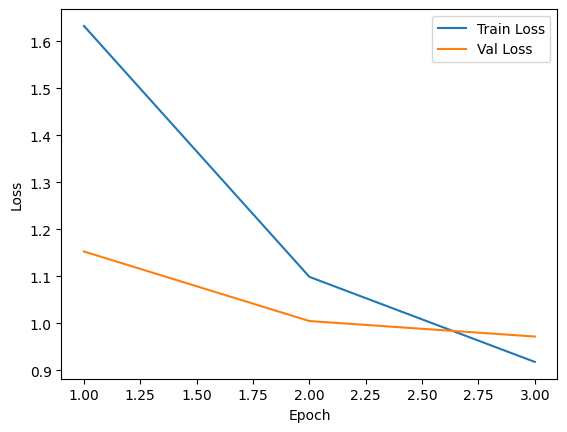

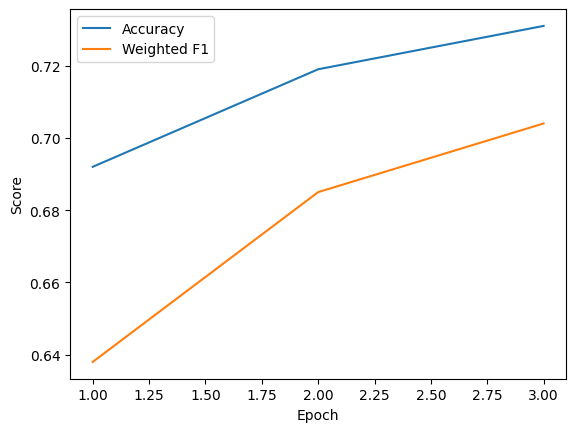

In [15]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3]
train_loss = [1.633, 1.099, 0.918]
val_loss = [1.153, 1.005, 0.972]
accuracy = [0.692, 0.719, 0.731]
f1 = [0.638, 0.685, 0.704]

plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, accuracy, label='Accuracy')
plt.plot(epochs, f1, label='Weighted F1')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.show()


**5 Evaluation **

In [17]:
eval_results = trainer.evaluate()
eval_results


{'eval_loss': 0.9716991782188416,
 'eval_accuracy': 0.7314241486068112,
 'eval_f1': 0.7042269995340293,
 'eval_runtime': 6.6966,
 'eval_samples_per_second': 385.869,
 'eval_steps_per_second': 24.191,
 'epoch': 3.0}

In [18]:
#Save Model & Labels
model.save_pretrained("model")
tokenizer.save_pretrained("model")

with open("labels.json", "w") as f:
    json.dump(label_encoder.classes_.tolist(), f)

print("Model and labels saved.")


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model and labels saved.


**SQLite Database Setup**

In [19]:
conn = sqlite3.connect("predictions.db", check_same_thread=False)
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS predictions (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    input_text TEXT,
    predicted_category TEXT,
    confidence REAL,
    created_at TEXT
)
""")

conn.commit()
print("Database initialized.")


Database initialized.


In [20]:
#Inference Function
with open("labels.json") as f:
    labels = json.load(f)

def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.softmax(outputs.logits, dim=1)
    confidence, predicted_idx = torch.max(probs, dim=1)

    return labels[predicted_idx.item()], confidence.item()


**FastAPI Backend**

In [21]:
from fastapi import FastAPI
from pydantic import BaseModel

app = FastAPI(title="News Category Classifier")

class InputText(BaseModel):
    text: str

@app.post("/predict")
def predict_category(request: InputText):
    category, confidence = predict(request.text)

    cursor.execute(
        "INSERT INTO predictions VALUES (NULL, ?, ?, ?, ?)",
        (request.text, category, confidence, datetime.utcnow().isoformat())
    )
    conn.commit()

    return {
        "predicted_category": category,
        "confidence": round(confidence, 2)
    }


To make the following public url accessing work, kindly create the ngrok authentication token and replace "YOUR_NGROK_AUTH_TOKEN" and "NGROK_AUTH_TOKEN"

In [ ]:
# from pyngrok import ngrok
# import uvicorn
# import os

# os.environ["NGROK_AUTH_TOKEN"] = "YOUR_NGROK_AUTH_TOKEN"

# ngrok.set_auth_token(os.environ["NGROK_AUTH_TOKEN"])

# ngrok.kill()

# public_url = ngrok.connect(8000)
# print("Public URL:", public_url)

# uvicorn.run(app, host="0.0.0.0", port=8000)
